# Power Keyword Analysis of 4th edition Dungeons and Dragons

For a while now I've had a database containing power descriptions in html, scraped from the compendium. Recently I thought I'd extract the keywords from these powers and summarise these by class and level, as an exercise in running MapReduce tasks in Spark. Here I'd like to explore that data to see if I can find anything interesting.

## loading/preprocessing data
First the .csv file will be loaded into pandas

In [66]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = [10,10]


data = pd.read_csv('./powerKeywordCount.txt',
                   names=['class_level','keyword','count'],
                   dtype={
                      'class_level':str,
                      'keyword':str,
                      'count':int},
                   quotechar="'",
                   quoting=csv.QUOTE_NONNUMERIC)
data.head()


,class_level,keyword,count
0,Artificer_13,close,1
1,Winter_Fury_11,encounter,1
2,Ranger_25,martial,16
3,Shock_Trooper_11,weapon,2
4,Draconic_Antithesis_11,encounter,1


The "Class_level" field contains the class that the power belongs to and the level of the power. Merging these two in this way was handy for the MapReduce step, but not super convenient here

In [67]:
import string
import re
there = re.compile(r'(?P<class>[a-zA-Z\'_\-]+?)_(?P<level>[0-9]+)')
def getClassLevel(instr):
    m = there.search(instr)
    thelevel =-1
    theclass = 'dunno'
    if m:
        thelevel = int(m.group('level'))
        theclass = m.group('class').replace('_',' ')
        
    return theclass, thelevel

data['class'],data['level'] = zip(*data['class_level'].map(getClassLevel))
data.head()



,class_level,keyword,count,class,level
0,Artificer_13,close,1,Artificer,13
1,Winter_Fury_11,encounter,1,Winter Fury,11
2,Ranger_25,martial,16,Ranger,25
3,Shock_Trooper_11,weapon,2,Shock Trooper,11
4,Draconic_Antithesis_11,encounter,1,Draconic Antithesis,11


I'm mainly interested in attack powers, which occur at specific character levels. Utility powers occur at even levels, so I'll ignore those. 

In [68]:
# aggregate attack powers
attackpowers = data[~data.level.isin([2,6,10,12,16,20,22,26,30])]
attackpowers = attackpowers[['class', 'level', 'keyword', 'count']]

# sum keyword totals over all levels
attacktotals = attackpowers[['class','keyword','count']]\
    .groupby(['class','keyword'])\
    .agg('sum') \
    .reset_index()
# attacktotals.head()

## PHB Class options
How well supported are the original Player's Handbook (PHB) classes? One metric is the total number of powers available, though this completely neglects feat support (which is beyond the scope of the data considered here). The "power source" for each class (arcane, divine, or martial in these cases) will also be considered here.

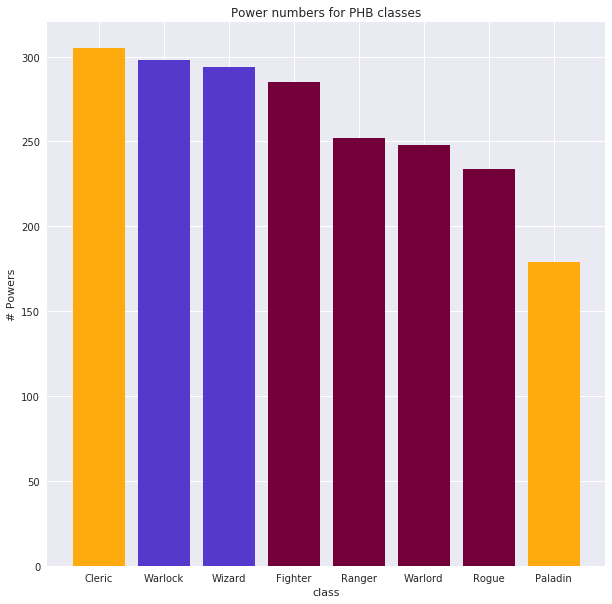

In [82]:
# PHB classes
classes = ['Fighter','Cleric','Rogue','Wizard','Ranger','Paladin','Warlock','Warlord']
sources = {}
colours = {}
for theclass in ['Fighter','Rogue','Ranger','Warlord']:
    sources[theclass] = 'Martial'
    colours[theclass] = sns.xkcd_rgb['merlot']

for theclass in ['Wizard','Warlock']:
    sources[theclass] = 'Arcane'
    colours[theclass] = sns.xkcd_rgb['blurple']

for theclass in ['Cleric','Paladin']:
    sources[theclass] = 'Divine'
    colours[theclass] = sns.xkcd_rgb['yellowish orange']

    
# get the total power counts for these, in descending order
classtotals = attacktotals[
    (attacktotals['class'].isin(classes)) & \
    (attacktotals['keyword'] == 'total')] \
    .sort_values(by=['count'],ascending=False)
# get the data columns as arrays
counts = classtotals['count'].values
classlabels = classtotals['class'].values
# colour bars based on power source
barcolours = [colours[tc] for tc in classlabels]
# colour the bars based on counts
# thecmap = plt.get_cmap('viridis')

# make the plot
fig,ax = plt.subplots();
ax.bar(np.arange(len(classes)),counts,color=barcolours);
ax.set_ylabel('# Powers');
ax.set_xlabel('class');
ax.set_title('Power numbers for PHB classes');
ax.set_xticks(np.arange(len(classes)));
ax.set_xticklabels(classlabels);


The plot above shows the total number of attack powers (summed over all levels) for each of the character classes covered by the PHB. Martial classes are coloured "merlot", arcane classes "blurple", and divine classes "yellowish orange" (thanks [xkcd](https://xkcd.com/color/rgb/))
This suprised me: I was expecting Fighters to have the most power options. My first 4E character was a fighter, and I played it from the early days of 4th edition. In addition to the PHB, fighter options appeared in a number of published sourcebooks (Martial Power 1 and 2), as well as numerous dragon magazine articles.

Fighters do have significantly more powers than the other martial classes, with ranger, warlord and rogue numbers being fairly similar. Divine classes have either the most or least options available (Paladins got shafted). Maybe there are  domain-related options available to Clerics, but not Paladins? As mentioned above, options for martial classes were included in two published "Martial Power" sourcebooks, while the Divine and Arcane power sources received a single sourcebook each. That being said, there are twice as many classes covered by the Martial power source, so maybe we should expect the content per sourcebook per class to be equal accross the PHB classes. 

## Bursts and Blasts amongst defenders

Powers can have different areas of effect. Attacks can be either melee, ranged, or cover an area (burst or blast, close or area). Other "attack" powers may confer status or stances on the character, such as a stance or a form, and thus have a "personal" effect. I wanted to see if there were any patterns in power Area of Effect (AoE) across defender classes.



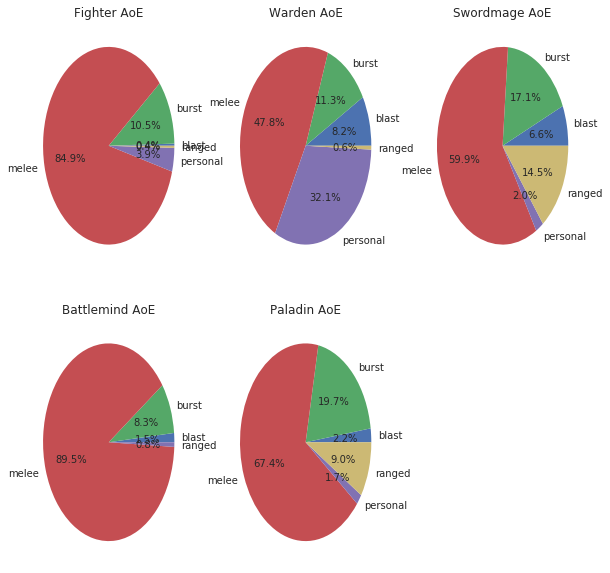

In [84]:
# Compare fraction of burst/melee/ranged powers by defender type
defenders = ['Fighter','Warden','Swordmage','Battlemind','Paladin']

kw = ['melee','ranged','burst','blast','personal']
explode = [0.0,0.05,0.10,0.05,0.2]

for plt_index in range(0,len(defenders)):
    theclass = defenders[plt_index]
    powers = attacktotals[attacktotals['class'] == theclass]
    powers = powers[powers['keyword'].isin(kw) ]
    plt.subplot(2,3,plt_index+1)
    plt.pie(powers['count'].values,labels=powers['keyword'].values,autopct='%1.1f%%')
    plt.title('{pclass} AoE'.format(pclass=theclass))
# FP[FP['keyword'].isin(kw) ]


Defender classes tend to favor melee powers. Wardens have a nice selection of AoE powers, with about 20% being either bursts or blasts. Wardens tend to have a lot of forms. These apply some sort of transformation to the warden, and generally also grant access to another attack power (which may have a melee or burst/blast keyword) that was not considered in the above plot. 

Paladins and Swordmages get a significant number of ranged attacks. These classes can use implements for spell-type effects, and these ranged powers are probably interrupts intended to protect other party members (e.g. dimensional vortex, price of cowardice). Fighters and Battleminds are 85-90% melee, while other classes have ~20% bursts/blasts, with Swordmages and Paladins also getting some ranged options.

## Weapliments
Certain character classes make use of both weapons (for physical attacks) and implements (for magical/divine "spell" type attacks). Certain classes (swordmages, for instance) can use weapons as implements. It might be interesting to look at the fraction of implement based powers for these classes across character levels. Ideally, I would look at the implement/weapon ratio, but for weapon powers the keyword "weapon" may show up twice (martial weapon, melee weapon) or once (martial weapon, close burst X) in the keyword block, which complicates things.

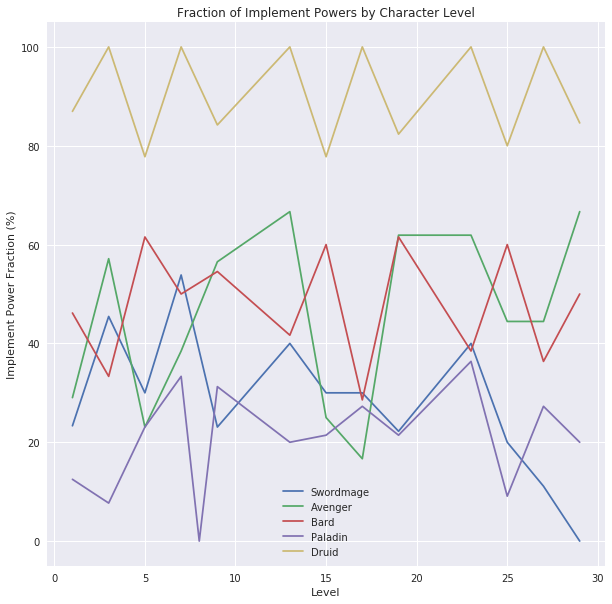

In [83]:
# plot ratio of implement/total power numbers
# select rows where keyword is either 'implement' or 'total'
slimmed = attackpowers.loc[ attackpowers['keyword'].isin(['implement','total'])]
# classes we are interested in (use both weapons and implements)       
classes = ['Swordmage', 'Avenger','Bard','Paladin','Druid']
# select data for these classes
classdata = slimmed[slimmed['class'].isin(classes)] 
# Create a pivot table
# want a row for each class/level combination
# want columns for implement and total (values from 'count' column)
ptable = pd.pivot_table(
    classdata,
    values='count',
    index=['class','level'],
    columns='keyword',
    fill_value=0)
# compute the implement/total ratio
ptable['ratio'] = ptable['implement']/ptable['total']

colorno=0

for pclass in classes:
    color='C{c}'.format(c=colorno)
    colorno+=1
    plotdata = ptable.loc[pclass,'ratio'].reset_index().values
    plt.plot(plotdata[:,0],plotdata[:,1]*100.0,color=color,label=pclass);
plt.legend();
plt.xlabel('Level');
plt.ylabel('Implement Power Fraction (%)');
plt.title('Fraction of Implement Powers by Character Level');


Druids are almost entirely implement based (if I'd played a druid before I might have known this). I'm guessing the non-implement powers relate to beast forms or something. Paladins tend to have the fewest implement attacks, although generally similar to Swordmages, the other defender class considered here. It's interesting to see all the non-druid classes having a similar fraction of implement powers at level 17, although this is a substantial drop for both the Avenger and Bard classes.